## SMAI assignment-3, Q-5

In [103]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
from torch import nn, save, load
from torch.utils.data import DataLoader,TensorDataset
from torch.optim import Adam
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

# Q-5.1 Multi-digit Recognition on Multi-MNIST Dataset 

In [20]:
#   Train dataset
#  Specify the path to your data folder
data_folder = 'C:/Users/JANAKSINH/SMAI_Assignments/SMAI_Assignment_3/Q_5/double_mnist_seed_123_image_size_64_64/train'

images = []
labels = []
# Loop through the subfolders, each representing a different class
for class_folder in os.listdir(data_folder):
    class_path = os.path.join(data_folder, class_folder)
    if os.path.isdir(class_path):
    
        # Loop through the images in the class folder
        for filename in os.listdir(class_path):
            if filename.endswith('.png'):
                image_path = os.path.join(class_path, filename)

                # Load the image using OpenCV and convert it to grayscale (if it's not already)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

                # Resize the image to 28x28 pixels
                image = cv2.resize(image, (28, 28))

                class12 = int(filename.split('_')[1].split('.')[0])
                class1 = class12//10
                class2 = class12 % 10
                #filter out the same digit iamges
                if (class1!=class2):
                    labels.append([class1, class2])
                    images.append(image)
# Convert the lists to NumPy arrays and reshape the data
images_train = np.array(images)
labels_train = np.array(labels)
images_train = images_train.reshape(images_train.shape[0], 1, 28, 28)

# Optionally, you can normalize the pixel values to be between 0 and 1
images_train = images_train / 255.0
print('images_train:',images_train.shape,'labels_train:',labels_train.shape)

images_train: (58000, 1, 28, 28) labels_train: (58000, 2)


Display several images from the filtered dataset to familiarize yourself with
the dual-digit nature of the images.

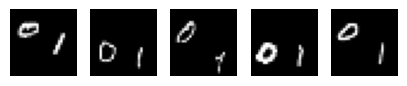

In [22]:
fig, axes = plt.subplots(1,5, figsize = (5,1))
sample_images = images_train[:5]
for i in range(5):
    axes[i].imshow(sample_images[i][0],'gray')
    axes[i].axis('off')

Test and validation data:

In [32]:
#   Validation dataset
#  Specify the path to your data folder
data_folder = 'C:/Users/JANAKSINH/SMAI_Assignments/SMAI_Assignment_3/Q_5/double_mnist_seed_123_image_size_64_64/val'

images = []
labels = []
# Loop through the subfolders, each representing a different class
for class_folder in os.listdir(data_folder):
    class_path = os.path.join(data_folder, class_folder)
    if os.path.isdir(class_path):
    
        # Loop through the images in the class folder
        for filename in os.listdir(class_path):
            if filename.endswith('.png'):
                image_path = os.path.join(class_path, filename)

                # Load the image using OpenCV and convert it to grayscale (if it's not already)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

                # Resize the image to 28x28 pixels
                image = cv2.resize(image, (28, 28))

                class12 = int(filename.split('_')[1].split('.')[0])
                class1 = class12//10
                class2 = class12 % 10
                #filter out the same digit iamges
                if (class1!=class2):
                    labels.append([class1, class2])
                    images.append(image)
# Convert the lists to NumPy arrays and reshape the data
images_valid = np.array(images)
labels_valid = np.array(labels)
images_valid = images_valid.reshape(images_valid.shape[0], 1, 28, 28)

# Optionally, you can normalize the pixel values to be between 0 and 1
images_valid = images_valid / 255.0
print('images_valid:',images_valid.shape,'labels_valid:',labels_valid.shape)

images_valid: (14000, 1, 28, 28) labels_valid: (14000, 2)


In [24]:
#  Test dataset
#  Specify the path to your data folder
data_folder = 'C:/Users/JANAKSINH/SMAI_Assignments/SMAI_Assignment_3/Q_5/double_mnist_seed_123_image_size_64_64/test'

images = []
labels = []
# Loop through the subfolders, each representing a different class
for class_folder in os.listdir(data_folder):
    class_path = os.path.join(data_folder, class_folder)
    if os.path.isdir(class_path):
    
        # Loop through the images in the class folder
        for filename in os.listdir(class_path):
            if filename.endswith('.png'):
                image_path = os.path.join(class_path, filename)

                # Load the image using OpenCV and convert it to grayscale (if it's not already)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

                # Resize the image to 28x28 pixels
                image = cv2.resize(image, (28, 28))

                class12 = int(filename.split('_')[1].split('.')[0])
                class1 = class12//10
                class2 = class12 % 10
                #filter out the same digit iamges
                if (class1!=class2):
                    labels.append([class1, class2])
                    images.append(image)
# Convert the lists to NumPy arrays and reshape the data
images_test = np.array(images)
labels_test = np.array(labels)
images_test = images_test.reshape(images_test.shape[0], 1, 28, 28)

# Optionally, you can normalize the pixel values to be between 0 and 1
images_test = images_test / 255.0
print('images_test:',images_test.shape,'labels_test:',labels_test.shape)

images_test: (18000, 1, 28, 28) labels_test: (18000, 2)


## 5.1.1 MLP on Multi-MNIST

1. Implement and train an MLP model on the MultiMNIST datase

In [39]:
#MLP model
class FlexibleMLP(nn.Module):
    def __init__(self, input_size=784, output_size=10, hidden_units_list = [128]):
        super(FlexibleMLP, self).__init__()

        # Input layer
        self.input_layer = nn.Linear(input_size, hidden_units_list[0])

        # Hidden layers
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_units_list) - 1):
            self.hidden_layers.append(nn.Linear(hidden_units_list[i], hidden_units_list[i+1]))
            self.hidden_layers.append(nn.ReLU())

        # Output layer
        self.output_layer = nn.Linear(hidden_units_list[-1], output_size)

    def forward(self, x):
        # x = torch.flatten(x, 1)  # Flatten the input if needed
        x = self.input_layer(x)
        
        # Pass through hidden layers
        for layer in self.hidden_layers:
            x = layer(x)
        x = self.output_layer(x)
        return x

# # Example usage:
# input_size = 784  # For MNIST (28x28)
# output_size = 10  # Number of classes
# hidden_units_list = [128, 64]  # List specifying the number of units in each hidden layer

# # Create the flexible model
# model = FlexibleMLP(input_size, output_size, hidden_units_list)

In [47]:
#train dataset preprocessing
mlb = MultiLabelBinarizer()
labels_train_encoded = mlb.fit_transform(labels_train)
images_train = images_train.astype('float32')
train_x_n = images_train.reshape(images_train.shape[0], 28*28)
train_x_n = torch.from_numpy(train_x_n)
train_y_n = torch.from_numpy(labels_train_encoded)
train_set = TensorDataset(train_x_n, train_y_n.type(torch.float32))

#validation dataset preprocessing
mlb = MultiLabelBinarizer()
labels_valid_encoded = mlb.fit_transform(labels_valid)
images_valid = images_valid.astype('float32')
valid_x_n = images_valid.reshape(images_valid.shape[0], 28*28)
valid_x_n = torch.from_numpy(valid_x_n)
valid_y_n = torch.from_numpy(labels_valid_encoded)
valid_set = TensorDataset(valid_x_n, valid_y_n)

#test dataset preprocessing
mlb = MultiLabelBinarizer()
labels_test_encoded = mlb.fit_transform(labels_test)
images_test = images_test.astype('float32')
test_x_n = images_test.reshape(images_test.shape[0], 28*28)
test_x_n = torch.from_numpy(test_x_n)
test_y_n = torch.from_numpy(labels_test_encoded)
test_set = TensorDataset(test_x_n, test_y_n)

In [89]:
#Train MLP
def train_mlp_model(hidden_units_list,epochs,batch_size,test_mode = False):
    input_size=784
    output_size=10
    learning_rate = 0.001
    model = FlexibleMLP(input_size, output_size, hidden_units_list)
    dataloader_train = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    dataloader_valid = DataLoader(valid_set, batch_size=batch_size)
    dataloader_test = DataLoader(test_set, batch_size=batch_size)
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(epochs):
        for data, target in dataloader_train:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            #validation accuracy
            total = 0
            correct = 0
        with torch.no_grad():
            if (test_mode==False):
                for data, target in dataloader_valid:
                    output = model(data)
                    output = 1 / (1 + np.exp(-output))
                    # predicted = (output>0.5).int()
                    top_indices = np.argsort(output, axis=1)[:, -2:]
                    # Create a binary matrix where only the top 2 maximum values are set to 1
                    predicted = np.zeros_like(output, dtype=int)
                    row_indices = np.arange(output.shape[0])[:, np.newaxis]
                    predicted[row_indices, top_indices] = 1
                    # _, predicted = torch.max(output.data, 1)
                    predicted = torch.from_numpy(predicted)
                    total += target.size(0)
                    correct += (predicted == target).sum().item()
                acc = 100*correct/(total*len(dataloader_valid))
            else:
                for data, target in dataloader_test:
                    output = model(data)
                    output = 1 / (1 + np.exp(-output))
                    # predicted = (output>0.5).int()
                    top_indices = np.argsort(output, axis=1)[:, -2:]
                    # Create a binary matrix where only the top 2 maximum values are set to 1
                    predicted = np.zeros_like(output, dtype=int)
                    row_indices = np.arange(output.shape[0])[:, np.newaxis]
                    predicted[row_indices, top_indices] = 1
                    # _, predicted = torch.max(output.data, 1)
                    predicted = torch.from_numpy(predicted)
                    total += target.size(0)
                    correct += (predicted == target).sum().item()
                acc = 100*correct/(total*len(dataloader_test))
            
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f},Accuracy: {acc}')

    # Save the trained model
    torch.save(model.state_dict(), 'flexible_mlp_model.pth')
    return acc,loss.item()

5.1.1         
2. Hyperparameter Tuning: Adjust the number of hidden layers and the
number of neurons within each layer to optimize performance and find
the best model.           
3. Report the accuracies on the train and validation set.

In [80]:
import wandb
import random

# start a new wandb run to track this script
wandb.init(project="Q-5.1.1 MLP on Multi-MNIST dataset hyperparameters tunining")

from itertools import product
h_param = {
        'hidden_units_list': [[128], [500,200], [128,64], [256,128]],
        'epochs' : [8],
        'batch_size': [1000]
        }
hyper_param = list(product(*h_param.values()))
J=0
accuracy = []
for i in hyper_param:
    print(f'Hyperparameters:{J}={i}')
    acc ,loss= train_mlp_model(i[0],i[1],i[2])
    wandb.log({"Hyper parameters pair":J,"accuracy": acc, "loss": loss})
    
    J += 1
    accuracy.append(acc)
wandb.finish()

Hyperparameters:0=([128], 8, 1000)
Epoch [1/8], Loss: 4.2574,Accuracy: 52.2530612244898
Epoch [2/8], Loss: 4.2174,Accuracy: 52.42448979591837
Epoch [3/8], Loss: 4.1602,Accuracy: 52.59591836734694
Epoch [4/8], Loss: 4.1457,Accuracy: 52.80816326530612
Epoch [5/8], Loss: 4.1405,Accuracy: 52.71836734693878
Epoch [6/8], Loss: 4.1175,Accuracy: 52.765306122448976
Epoch [7/8], Loss: 4.1439,Accuracy: 52.84795918367347
Epoch [8/8], Loss: 4.0870,Accuracy: 52.803061224489795
Hyperparameters:1=([500, 200], 8, 1000)
Epoch [1/8], Loss: 4.1172,Accuracy: 52.74387755102041
Epoch [2/8], Loss: 3.9479,Accuracy: 53.621428571428574
Epoch [3/8], Loss: 3.7886,Accuracy: 54.093877551020405
Epoch [4/8], Loss: 3.6787,Accuracy: 54.85510204081633
Epoch [5/8], Loss: 3.4467,Accuracy: 55.433673469387756
Epoch [6/8], Loss: 3.3375,Accuracy: 55.683673469387756
Epoch [7/8], Loss: 3.2364,Accuracy: 56.15204081632653
Epoch [8/8], Loss: 3.1669,Accuracy: 56.6265306122449
Hyperparameters:2=([128, 64], 8, 1000)
Epoch [1/8], Loss:

Hyper parameters pair,▁▃▆█
accuracy,▁█▄▆
loss,█▁▅▃
Hyper parameters pair,3
accuracy,55.53878
loss,3.48545


In [83]:
# Max_accu_hy_param_index = 56
Max_accu_hy_param_index = np.argmax(accuracy)
# print(f"We get this accuracy for this hyperparameters\n(hidden_units_list,epochs,batch_size): {hyper_param[Max_accu_hy_param_index]}.")
print(f"The maximum accuracy{Max_accu_hy_param_index}={accuracy[Max_accu_hy_param_index]} \nWe get this accuracy for this hyperparameters\n(hidden_units_list,epochs,batch_size): {hyper_param[Max_accu_hy_param_index]}.")

The maximum accuracy1=56.6265306122449 
We get this accuracy for this hyperparameters
(hidden_units_list,epochs,batch_size): ([500, 200], 8, 1000).


5.1.1       
4. Evaluate your trained model on test set and report the accuracy.

In [84]:
i = hyper_param[Max_accu_hy_param_index]
print(f'Hyperparameters:{J}={i}')
acc ,loss= train_mlp_model(i[0],i[1],i[2],test_mode=True)
print("Accuracy and loss on the test dataset for best hyperparameters is :",acc,loss)

Hyperparameters:4=([500, 200], 8, 1000)
Epoch [1/8], Loss: 4.1587,Accuracy: 40.443827160493825
Epoch [2/8], Loss: 4.0021,Accuracy: 41.2679012345679
Epoch [3/8], Loss: 3.8311,Accuracy: 41.970987654320986
Epoch [4/8], Loss: 3.6614,Accuracy: 42.79382716049383
Epoch [5/8], Loss: 3.4484,Accuracy: 43.69444444444444
Epoch [6/8], Loss: 3.3044,Accuracy: 43.88703703703704
Epoch [7/8], Loss: 3.2393,Accuracy: 44.269753086419755
Epoch [8/8], Loss: 3.1038,Accuracy: 44.5679012345679
Accuracy and loss on the test dataset for best hyperparameters is : 44.5679012345679 3.103806972503662


## 5.1.2 CNN on Multi-MNIST

1. Design and train a CNN model on the MultiMNIST dataset

In [90]:
# CNN model
class MY_CNN(nn.Module):

    def __init__(self,kernel_size = (3,3),stride = (1,1), dropout_rate = 0.25):
        super(MY_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1,32,kernel_size,stride=stride, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d((2,2),stride=(2,2))
        self.conv2 = nn.Conv2d(32,64,kernel_size,stride=stride, padding=1)
      
        out1 =  int(self.calculate_out(28, kernel_size, stride)/2)
        self.out = int(self.calculate_out(out1, kernel_size, stride)/2)
     
        self.dropout = nn.Dropout(dropout_rate)
        self.out_features = 64*self.out*self.out
        self.fc = nn.Linear(self.out_features,10)   #(out_features,in_features)
        self.softmax = nn.Softmax(dim=1)

    def calculate_out(self, input_size, kernel_size, stride):
            return ((input_size + 2 - (kernel_size[0] - 1) - 1) / stride[0]) + 1
    def forward(self,x):
        x = self.relu(self.conv1(x))    #N,32,28,28
        x = self.pool(x)                #N,32,14,14
        x = self.relu(self.conv2(x))    #N,64,14,14
        x = self.pool(x)                #N,64,7,7

        x = x.view(-1,self.out_features) #N,64*7*7
        x = self.dropout(x)              #N,64*7*7
        x = self.fc(x)                  #N,10
        # x = self.softmax(x)
        return x


In [97]:
def train_CNN_model(learning_rate, epochs, batch_size, kernel_size, stride, dropout_rate, test_mode=False):
    model = MY_CNN(kernel_size, stride, dropout_rate)
    dataloader_train = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    dataloader_valid = DataLoader(valid_set, batch_size=batch_size)
    dataloader_test = DataLoader(test_set, batch_size=batch_size)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    n_total_steps = len(dataloader_train)

    for epoch in range(epochs):
        running_loss = 0.0

        for i, (images, labels) in enumerate(dataloader_train):
            # images = images.to(device)
            # labels = labels.to(device)
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            # Backward and optimize
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            running_loss += loss.item()
            total=0
            correct=0
        #Accuracy calculaltion:
        with torch.no_grad():
            n_correct = 0
            if(test_mode==False):
              n_samples = len(dataloader_valid.dataset)
              for images, labels in dataloader_valid:

                #   images = images.to(device)
                #   labels = labels.to(device)
                output = model(images)
                output = 1 / (1 + np.exp(-output))
              
                top_indices = np.argsort(output, axis=1)[:, -2:]
                # Create a binary matrix where only the top 2 maximum values are set to 1
                predicted = np.zeros_like(output, dtype=int)
                row_indices = np.arange(output.shape[0])[:, np.newaxis]
                predicted[row_indices, top_indices] = 1
                # _, predicted = torch.max(output.data, 1)
                predicted = torch.from_numpy(predicted)
                total += target.size(0)
                correct += (predicted == labels).sum().item()
              acc = 100*correct/(total*len(dataloader_valid))
            else:
              
              for images, labels in dataloader_test:

                # images = images.to(device)
                # labels = labels.to(device)
                output = model(images)
                output = 1 / (1 + np.exp(-output))

                top_indices = np.argsort(output, axis=1)[:, -2:]
                # Create a binary matrix where only the top 2 maximum values are set to 1
                predicted = np.zeros_like(output, dtype=int)
                row_indices = np.arange(output.shape[0])[:, np.newaxis]
                predicted[row_indices, top_indices] = 1
            
                predicted = torch.from_numpy(predicted)
                total += target.size(0)
                correct += (predicted == labels).sum().item()
              acc = 100*correct/(total*len(dataloader_valid))
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f},Accuracy: {acc}')

    PATH = './Q_5_cnn.pth'
    torch.save(model.state_dict(), PATH)
    return acc, loss.item()

In [93]:
images_train.shape

(58000, 1, 28, 28)

In [98]:
#train dataset preprocessing
mlb = MultiLabelBinarizer()
labels_train_encoded = mlb.fit_transform(labels_train)
train_x_n = images_train.astype('float32')
# train_x_n = images_train.reshape(images_train.shape[0], 28*28)
train_x_n = torch.from_numpy(train_x_n)
train_y_n = torch.from_numpy(labels_train_encoded)
train_set = TensorDataset(train_x_n, train_y_n.type(torch.float32))

#validation dataset preprocessing
mlb = MultiLabelBinarizer()
labels_valid_encoded = mlb.fit_transform(labels_valid)
valid_x_n = images_valid.astype('float32')
# valid_x_n = images_valid.reshape(images_valid.shape[0], 28*28)
valid_x_n = torch.from_numpy(valid_x_n)
valid_y_n = torch.from_numpy(labels_valid_encoded)
valid_set = TensorDataset(valid_x_n, valid_y_n)

#test dataset preprocessing
mlb = MultiLabelBinarizer()
labels_test_encoded = mlb.fit_transform(labels_test)
test_x_n = images_test.astype('float32')
# test_x_n = images_test.reshape(images_test.shape[0], 28*28)
test_x_n = torch.from_numpy(test_x_n)
test_y_n = torch.from_numpy(labels_test_encoded)
test_set = TensorDataset(test_x_n, test_y_n)

5.1.2          
2. Hyperparameter Tuning: Experiment with different learning rates, kernel
sizes, and dropout rates to determine the optimal configuration.   
3. Report the accuracies on the train and validation set.


In [99]:
import wandb
import random

# start a new wandb run to track this script
wandb.init(project="Q-5.1.2 Hyperparameters tunining of CNN for Multi-MNIST dataset")

from itertools import product
h_param = {
        'learning_rate': [0.005, 0.001],
        'epochs' : [8],
        'batch_size': [1000],
        'kernel_sizes' : [(3,3),(5,5)],
        'strides' : [(1,1)],
        'dropout_rate' : [0.15,0.25]
        }
hyper_param = list(product(*h_param.values()))
J=0
accuracy = []
for i in hyper_param:
    print(f'Hyperparameters:{J}={i}')
    acc ,loss = train_CNN_model(i[0], i[1], i[2], i[3], i[4], i[5])
    wandb.log({"Hyper parameters pair":J,"accuracy": acc, "loss": loss})
    
    J += 1
    accuracy.append(acc)
wandb.finish()

Hyperparameters:0=(0.005, 8, 1000, (3, 3), (1, 1), 0.15)
Epoch [1/8], Loss: 4.5180,Accuracy: 49.21632653061224
Epoch [2/8], Loss: 4.1153,Accuracy: 53.234693877551024
Epoch [3/8], Loss: 3.9659,Accuracy: 54.316326530612244
Epoch [4/8], Loss: 3.8964,Accuracy: 54.10918367346939
Epoch [5/8], Loss: 3.6547,Accuracy: 55.44795918367347
Epoch [6/8], Loss: 3.5370,Accuracy: 56.35510204081633


wandb: Network error resolved after 0:00:08.443474, resuming normal operation.


Epoch [7/8], Loss: 3.3998,Accuracy: 56.51734693877551
Epoch [8/8], Loss: 3.3286,Accuracy: 56.29387755102041
Hyperparameters:1=(0.005, 8, 1000, (3, 3), (1, 1), 0.25)
Epoch [1/8], Loss: 4.2894,Accuracy: 52.1530612244898
Epoch [2/8], Loss: 3.7434,Accuracy: 54.97244897959184
Epoch [3/8], Loss: 3.5973,Accuracy: 55.87244897959184
Epoch [4/8], Loss: 3.4161,Accuracy: 56.391836734693875
Epoch [5/8], Loss: 3.3055,Accuracy: 56.76428571428571
Epoch [6/8], Loss: 3.2471,Accuracy: 57.073469387755104
Epoch [7/8], Loss: 3.1647,Accuracy: 57.255102040816325
Epoch [8/8], Loss: 3.1270,Accuracy: 57.3
Hyperparameters:2=(0.005, 8, 1000, (5, 5), (1, 1), 0.15)
Epoch [1/8], Loss: 3.7243,Accuracy: 55.09795918367347
Epoch [2/8], Loss: 3.3187,Accuracy: 56.48877551020408
Epoch [3/8], Loss: 3.1006,Accuracy: 57.398979591836735
Epoch [4/8], Loss: 3.0037,Accuracy: 57.36938775510204
Epoch [5/8], Loss: 2.9322,Accuracy: 57.85510204081633
Epoch [6/8], Loss: 2.8544,Accuracy: 58.29387755102041
Epoch [7/8], Loss: 2.7831,Accura

Hyper parameters pair,▁▂▃▄▅▆▇█
accuracy,▃▄▅▁████
loss,▇▅▄█▂▂▁▁
Hyper parameters pair,7
accuracy,61.63061
loss,2.38458


In [101]:
Max_accu_hy_param_index = 56
Max_accu_hy_param_index = np.argmax(accuracy)
print(f"The maximum accuracy{Max_accu_hy_param_index} = {accuracy[Max_accu_hy_param_index]}")
print(f"We get this accuracy for this hyperparameters\n(learning_rate,epochs,batch_size,kernel_sizes,strides,dropout_rate): {hyper_param[Max_accu_hy_param_index]}.")

The maximum accuracy6 = 61.99183673469388
We get this accuracy for this hyperparameters
(learning_rate,epochs,batch_size,kernel_sizes,strides,dropout_rate): (0.001, 8, 1000, (5, 5), (1, 1), 0.15).


5.1.2     
4. Evaluate your trained model on test set and report the accuracy

In [102]:
i = hyper_param[Max_accu_hy_param_index]
print(f'Hyperparameters:{J}={i}')
acc ,loss = train_CNN_model(i[0], i[1], i[2], i[3], i[4], i[5])
print(f"Accuracy and loss on the test dataset for best hyperparameters is :")
print("Accuracy:",acc," Loss:",loss)

Hyperparameters:8=(0.001, 8, 1000, (5, 5), (1, 1), 0.15)
Epoch [1/8], Loss: 3.8637,Accuracy: 54.55612244897959
Epoch [2/8], Loss: 3.3018,Accuracy: 58.26938775510204
Epoch [3/8], Loss: 2.9666,Accuracy: 60.022448979591836
Epoch [4/8], Loss: 2.6951,Accuracy: 60.48877551020408
Epoch [5/8], Loss: 2.5584,Accuracy: 60.618367346938776
Epoch [6/8], Loss: 2.4614,Accuracy: 61.41122448979592
Epoch [7/8], Loss: 2.4232,Accuracy: 61.659183673469386
Epoch [8/8], Loss: 2.3761,Accuracy: 61.94387755102041
Accuracy and loss on the test dataset for best hyperparameters is :
Accuracy: 61.94387755102041  Loss: 2.3761250972747803


# Q-5.2 Permuted MNIST

Data import and preprocess

In [104]:
data = np.load('permuted_mnist.npz')
train_images_n = data['train_images']
train_labels_n = data['train_labels']
test_images = data['test_images']
test_labels = data['test_labels']
print('train_images.shape:',train_images_n.shape,"train_labels.shape:",train_labels_n.shape, 
'\ntest_images.shape:', test_images.shape,"test_labels.shape:",test_labels.shape)

train_images.shape: (60000, 28, 28) train_labels.shape: (60000,) 
test_images.shape: (10000, 28, 28) test_labels.shape: (10000,)


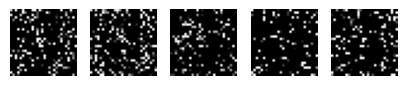

In [106]:
#Data Samples visulization
fig, axes = plt.subplots(1,5, figsize = (5,1))
sample_images = train_images_n[:5]
for i in range(5):
    axes[i].imshow(sample_images[i],'gray')
    axes[i].axis('off')

In [117]:
#separate the training, testing and validation data
train_images, valid_images, train_labels, valid_labels = train_test_split(train_images_n,train_labels_n,test_size=0.16666,random_state=1)
print("Shape of the train, test and validaton data:",train_images.shape,test_images.shape,valid_images.shape)
print("Shape of the train, test and validaton label:",train_labels.shape,test_labels.shape,valid_labels.shape)

Shape of the train, test and validaton data: (50000, 28, 28) (10000, 28, 28) (10000, 28, 28)
Shape of the train, test and validaton label: (50000,) (10000, 1) (10000,)


#### 5.2.1 MLP on Permuted-MNIST

5.2.1 Data preprocessing

In [118]:
#train dataset preprocessing
train_labels = train_labels.reshape(-1,1)
mlb = MultiLabelBinarizer()
labels_train_encoded = mlb.fit_transform(train_labels)
train_images = train_images.astype('float32')
train_x_n = train_images.reshape(train_images.shape[0], 28*28)
train_x_n = torch.from_numpy(train_x_n)
train_y_n = torch.from_numpy(labels_train_encoded)
train_set = TensorDataset(train_x_n, train_y_n.type(torch.float32))

#validation dataset preprocessing
valid_labels = valid_labels.reshape(-1,1)
mlb = MultiLabelBinarizer()
labels_valid_encoded = mlb.fit_transform(valid_labels)
valid_images = valid_images.astype('float32')
valid_x_n = valid_images.reshape(valid_images.shape[0], 28*28)
valid_x_n = torch.from_numpy(valid_x_n)
valid_y_n = torch.from_numpy(labels_valid_encoded)
valid_set = TensorDataset(valid_x_n, valid_y_n)

#test dataset preprocessing
test_labels = test_labels.reshape(-1,1)
mlb = MultiLabelBinarizer()
labels_test_encoded = mlb.fit_transform(test_labels)
test_images = test_images.astype('float32')
test_x_n = test_images.reshape(test_images.shape[0], 28*28)
test_x_n = torch.from_numpy(test_x_n)
test_y_n = torch.from_numpy(labels_test_encoded)
test_set = TensorDataset(test_x_n, test_y_n)

5.2.1 Hyperparameter Tuning

In [110]:
import wandb
import random

# start a new wandb run to track this script
wandb.init(project="Q-5.2.1 MLP on Permuted-MNIST dataset hyperparameters tunining")

from itertools import product
h_param = {
        'hidden_units_list': [[128], [128,64], [256,128]],
        'epochs' : [8],
        'batch_size': [1000]
        }
hyper_param = list(product(*h_param.values()))
J=0
accuracy = []
for i in hyper_param:
    print(f'Hyperparameters:{J}={i}')
    acc ,loss= train_mlp_model(i[0],i[1],i[2])
    wandb.log({"Hyper parameters pair":J,"accuracy": acc, "loss": loss})
    
    J += 1
    accuracy.append(acc)
wandb.finish()

Hyperparameters:0=([128], 8, 1000)


C:\Users\JANAKSINH\AppData\Local\Temp\ipykernel_6780\1314646254.py:30: RuntimeWarning: overflow encountered in exp
  output = 1 / (1 + np.exp(-output))


Epoch [1/8], Loss: 2.5434,Accuracy: 79.074
Epoch [2/8], Loss: 1.9751,Accuracy: 79.558
Epoch [3/8], Loss: 1.1823,Accuracy: 81.422
Epoch [4/8], Loss: 1.0350,Accuracy: 83.956
Epoch [5/8], Loss: 0.7728,Accuracy: 84.692
Epoch [6/8], Loss: 0.7991,Accuracy: 84.526
Epoch [7/8], Loss: 0.8245,Accuracy: 85.184
Epoch [8/8], Loss: 0.7778,Accuracy: 85.586
Hyperparameters:1=([128, 64], 8, 1000)
Epoch [1/8], Loss: 0.3932,Accuracy: 88.906
Epoch [2/8], Loss: 0.2690,Accuracy: 89.272
Epoch [3/8], Loss: 0.1779,Accuracy: 89.384
Epoch [4/8], Loss: 0.2018,Accuracy: 89.482
Epoch [5/8], Loss: 0.1526,Accuracy: 89.546
Epoch [6/8], Loss: 0.1902,Accuracy: 89.596
Epoch [7/8], Loss: 0.1522,Accuracy: 89.624
Epoch [8/8], Loss: 0.1174,Accuracy: 89.65
Hyperparameters:2=([256, 128], 8, 1000)
Epoch [1/8], Loss: 0.3195,Accuracy: 89.242
Epoch [2/8], Loss: 0.2219,Accuracy: 89.442
Epoch [3/8], Loss: 0.1723,Accuracy: 89.538
Epoch [4/8], Loss: 0.1458,Accuracy: 89.61
Epoch [5/8], Loss: 0.1436,Accuracy: 89.62
Epoch [6/8], Loss: 0.

Hyper parameters pair,▁▅█
accuracy,▁██
loss,█▁▁
Hyper parameters pair,2
accuracy,89.69
loss,0.07086


In [112]:

Max_accu_hy_param_index = np.argmax(accuracy)
print(f"The maximum accuracy{Max_accu_hy_param_index}={accuracy[Max_accu_hy_param_index]} \nWe get this accuracy for this hyperparameters\n(hidden_units_list,epochs,batch_size): {hyper_param[Max_accu_hy_param_index]}.")

The maximum accuracy2=89.69 
We get this accuracy for this hyperparameters
(hidden_units_list,epochs,batch_size): ([256, 128], 8, 1000).


5.2.1 Evaluate the model for best hyperpameter on test set

In [114]:
i = hyper_param[Max_accu_hy_param_index]
print(f'Hyperparameters:{J}={i}')
acc ,loss= train_mlp_model(i[0],i[1],i[2],test_mode=True)
print(f"Accuracy and loss on the test dataset for best hyperparameters is :")
print("Accuracy:",acc," Loss:",loss)

Hyperparameters:3=([256, 128], 8, 1000)
Epoch [1/8], Loss: 0.3279,Accuracy: 89.262
Epoch [2/8], Loss: 0.2415,Accuracy: 89.534
Epoch [3/8], Loss: 0.1737,Accuracy: 89.596
Epoch [4/8], Loss: 0.1305,Accuracy: 89.688
Epoch [5/8], Loss: 0.1002,Accuracy: 89.724
Epoch [6/8], Loss: 0.0859,Accuracy: 89.74
Epoch [7/8], Loss: 0.1128,Accuracy: 89.744
Epoch [8/8], Loss: 0.0556,Accuracy: 89.728
Accuracy and loss on the test dataset for best hyperparameters is :
Accuracy: 89.728  Loss: 0.055619820952415466


## 5.2.2  CNN on Permuted-MNIST

5.2.2 Data preprocessing

In [123]:
#train dataset preprocessing
train_labels = train_labels.reshape(-1,1)
mlb = MultiLabelBinarizer()
labels_train_encoded = mlb.fit_transform(train_labels)
train_x_n = train_images.astype('float32')
train_x_n = train_images.reshape(train_images.shape[0],1, 28,28)
train_x_n = torch.from_numpy(train_x_n)
train_y_n = torch.from_numpy(labels_train_encoded)
train_set = TensorDataset(train_x_n, train_y_n.type(torch.float32))

#validation dataset preprocessing
valid_labels = valid_labels.reshape(-1,1)
mlb = MultiLabelBinarizer()
labels_valid_encoded = mlb.fit_transform(valid_labels)
valid_x_n = valid_images.astype('float32')
valid_x_n = valid_images.reshape(valid_images.shape[0],1, 28,28)
valid_x_n = torch.from_numpy(valid_x_n)
valid_y_n = torch.from_numpy(labels_valid_encoded)
valid_set = TensorDataset(valid_x_n, valid_y_n)

#test dataset preprocessing
test_labels = test_labels.reshape(-1,1)
mlb = MultiLabelBinarizer()
labels_test_encoded = mlb.fit_transform(test_labels)
test_x_n = test_images.astype('float32')
test_x_n = test_images.reshape(test_images.shape[0],1, 28,28)
test_x_n = torch.from_numpy(test_x_n)
test_y_n = torch.from_numpy(labels_test_encoded)
test_set = TensorDataset(test_x_n, test_y_n)

5.2.2 Hyperparameter tuning

In [124]:
import wandb
import random

# start a new wandb run to track this script
wandb.init(project="Q-5.2.2 Hyperparameters tunining of CNN for Permuted-MNIST dataset")

from itertools import product
h_param = {
        'learning_rate': [0.005, 0.001],
        'epochs' : [8],
        'batch_size': [1000],
        'kernel_sizes' : [(3,3),(5,5)],
        'strides' : [(1,1)],
        'dropout_rate' : [0.15,0.25]
        }
hyper_param = list(product(*h_param.values()))
J=0
accuracy = []
for i in hyper_param:
    print(f'Hyperparameters:{J}={i}')
    acc ,loss = train_CNN_model(i[0], i[1], i[2], i[3], i[4], i[5])
    wandb.log({"Hyper parameters pair":J,"accuracy": acc, "loss": loss})
    
    J += 1
    accuracy.append(acc)
wandb.finish()

Hyperparameters:0=(0.005, 8, 1000, (3, 3), (1, 1), 0.15)
Epoch [1/8], Loss: 1.0179,Accuracy: 86.338
Epoch [2/8], Loss: 0.7320,Accuracy: 87.708
Epoch [3/8], Loss: 0.6016,Accuracy: 87.964
Epoch [4/8], Loss: 0.6394,Accuracy: 88.314
Epoch [5/8], Loss: 0.5175,Accuracy: 88.588
Epoch [6/8], Loss: 0.4861,Accuracy: 88.61
Epoch [7/8], Loss: 0.4855,Accuracy: 88.626
Epoch [8/8], Loss: 0.4495,Accuracy: 88.724
Hyperparameters:1=(0.005, 8, 1000, (3, 3), (1, 1), 0.25)
Epoch [1/8], Loss: 1.4364,Accuracy: 84.256
Epoch [2/8], Loss: 1.0654,Accuracy: 86.496
Epoch [3/8], Loss: 0.8825,Accuracy: 87.144
Epoch [4/8], Loss: 0.7937,Accuracy: 87.718
Epoch [5/8], Loss: 0.6694,Accuracy: 87.816
Epoch [6/8], Loss: 0.7062,Accuracy: 87.544
Epoch [7/8], Loss: 0.6545,Accuracy: 88.018
Epoch [8/8], Loss: 0.6792,Accuracy: 88.136
Hyperparameters:2=(0.005, 8, 1000, (5, 5), (1, 1), 0.15)
Epoch [1/8], Loss: 1.8727,Accuracy: 79.776
Epoch [2/8], Loss: 0.9049,Accuracy: 86.974
Epoch [3/8], Loss: 0.7113,Accuracy: 87.828
Epoch [4/8], 

KeyboardInterrupt: 

In [125]:
Max_accu_hy_param_index = 56
Max_accu_hy_param_index = np.argmax(accuracy)
print(f"The maximum accuracy{Max_accu_hy_param_index} = {accuracy[Max_accu_hy_param_index]}")
print(f"We get this accuracy for this hyperparameters\n(learning_rate,epochs,batch_size,kernel_sizes,strides,dropout_rate): {hyper_param[Max_accu_hy_param_index]}.")

The maximum accuracy4 = 89.33
We get this accuracy for this hyperparameters
(learning_rate,epochs,batch_size,kernel_sizes,strides,dropout_rate): (0.001, 8, 1000, (3, 3), (1, 1), 0.15).


5.2.2 Evaluate the model for best hyperpameter on test set

In [126]:
i = hyper_param[Max_accu_hy_param_index]
print(f'Hyperparameters:{J}={i}')
acc ,loss = train_CNN_model(i[0],3, i[2], i[3], i[4], i[5])
print(f"Accuracy and loss on the test dataset for best hyperparameters is :")
print("Accuracy:",acc," Loss:",loss)

Hyperparameters:6=(0.001, 8, 1000, (3, 3), (1, 1), 0.15)
Epoch [1/3], Loss: 0.5596,Accuracy: 88.438


# Q_5.3  Analysis

Q-1. Contrast the performances of MLP vs. CNN for both datasets      
Answer:      
1. CNN is giving better performance for the complex image dataset.(for the Double-MNIST dataset the CNN(89%) give better accuracy then MLP(56%)).
2. for complex dataset MLP have more problem of overfitting compare to CNN.
3. for the permuted dataset CNN and MLP both give similar performance.

Q-2. Discuss the observed differences and any challenges faced during training
and evaluation.        
Answer:
1. CNN required more computational resources compare to MLP. So, for hyper parameter tuning CNN take more time.
2. Due to low computational resources the process crashed many time.


Q-3. Compare the potential for overfitting between a CNN and an MLP in the
context of datasets in Task 5. Use training vs. validation loss/accuracy
plots to support your observations.               
Answer:    
For the Double-MNIST dataset MLP have more overfitting problem compare to CNN, which i observed in the task 5.

